# gbm3d.m output

Requirements: python 3

In [48]:
import numpy as np
import os
import scipy.io
import pandas as pd
from skimage import measure, morphology
import matplotlib.pyplot as plt
from matplotlib import cm
import pymesh
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_extraction.image import img_to_graph
import matplotlib.colors as colors
import matplotlib as mpl
#plt.switch_backend('agg')
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif'})
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{bm}')
mpl.rcParams["axes.titlesize"] = 12
mpl.rcParams["axes.labelsize"] = 12
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["figure.titlesize"] = 16
mpl.rcParams["legend.fontsize"] = 12
mpl.rcParams["axes.axisbelow"] = True

%matplotlib inline

In [49]:
# Load the output of gbm3d.m after many iterations.
grains = scipy.io.loadmat("../../esedoglu/v1_largescale/grains.mat")['grains']
n_grains = len(grains)
print("Loaded %d grains" % n_grains)

Loaded 673 grains


In [3]:
# Notice that indices here goes from 0 to N-1
dims = (128,128,128)

def load_grain(k):
    u = -np.ones(dims)
    ind = grains[k][0]-1
    [x, y, z] = np.unravel_index(ind, dims, order='F')
    val = grains[k][1]
    u[y,x,z] = val
    return u

def build_surface(grain):
    verts, faces = measure.marching_cubes_classic(grain, 0, spacing=(1, 1, 1))
    return verts, faces

def plot_surface(ax, verts, faces):
    ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2],
                cmap=cm.rainbow, lw=1)
def plot_grain(ax, grain):
    verts, faces = build_surface(grain)
    plot_surface(ax, verts, faces)

## Plot structure (Matplotlib backend)

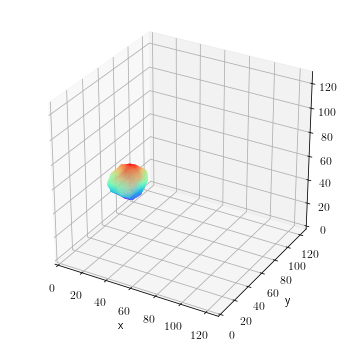

In [4]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(0,127)
ax.set_zlim(0,127)
ax.set_ylim(0,127)
ax.set_xlabel("x")
ax.set_ylabel("y")
# Load grain from MATLAB output
g = load_grain(3)
plot_grain(ax, g)

## Analyze structure

### 1) Generate different planes and perform several cuts

In [50]:
# Generate different cut levels
levels = np.arange(10,120,10).astype(int)
results_per_level = [[None for i in range(n_grains)] for level in levels]
# For each grain intersect with each of the different planes
for i in range(n_grains):
    # Load grain from MATLAB output
    g = load_grain(i)
    # Get vertices and faces (grain triangulation)
    verts, faces = build_surface(g)
    # Build high level mesh
    mesh = pymesh.form_mesh(verts, faces)
    # Iterate over planes
    for j, level in enumerate(levels):
        eps = 2
        X1 = np.array([127,level,127])
        X3 = np.array([0,level+eps,0])
        plane = pymesh.generate_box_mesh(X1, X3)
    
        result = pymesh.boolean(mesh, plane, operation="intersection", engine="carve")
        if len(result.vertices) > 0:
            results_per_level[j][i] = result

In [51]:
# Filter results, some Nones are just non intersecting grains 
#results = [r for r in results if r is not None]
for i, results in enumerate(results_per_level):
    results_per_level[i] = [r for r in results_per_level[i] if r is not None]

### Plot resulting cuts

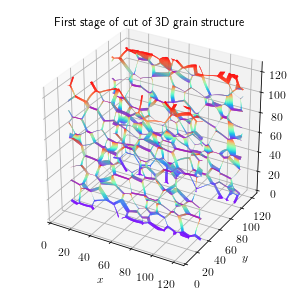

In [28]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(0,127)
ax.set_zlim(0,127)
ax.set_ylim(0,127)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
for results in results_per_level:
    for r in results:
        plot_surface(ax, r.vertices, r.faces)
ax.set_title("First stage of cut of 3D grain structure")
plt.savefig("cut.pdf")
plt.show()

### 2) Filter results to obtain 2D discrete images

In [52]:
# Join all the valid results and postprocess to 2D
all_finals = []
all_skeletons = []
for level, results in zip(levels, results_per_level):
    finals = []
    for r in results:
        mask = r.vertices[:,1] == level
        tmp = r.vertices[mask]
        finals.append(tmp[:, [0,2]])
    finals = np.vstack(finals)
    # Generate image
    finals = (finals * 4).astype(int)
    # Binarize output
    M = np.zeros((np.max(finals)+1, np.max(finals)+1))
    M[finals[:,1], finals[:,0]] = 1
    dit = morphology.binary_dilation(M, selem=np.ones((4,4)))
    skt = morphology.skeletonize(dit)
    all_finals.append(finals)
    all_skeletons.append(skt)

### Plot extracted 2D discrete cut

In [36]:
for level, finals in zip(levels, all_finals):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.plot(finals[:,0], finals[:,1], '.', ms=1)
    ax.grid()
    ax.set_xlabel("x")
    ax.set_ylabel("z")
    ax.set_xlim(0,np.max(finals))
    ax.set_ylim(0,np.max(finals))
    ax.set_title("2D discrete data extracted from cut")
    plt.savefig("example_%d.pdf" % level)
    #plt.show()
plt.close()
plt.clf()

<Figure size 360x360 with 0 Axes>

In [55]:
basefolder = "exp_02"
os.system("rm -rf %s && mkdir %s" % (basefolder, basefolder))
for level, skt in zip(levels, all_skeletons):
    fig = plt.figure(figsize=(10,10))
    plt.imshow(skt[::-1], cmap=cm.binary)
    plt.axis("off")
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.savefig(basefolder+"/out_%d.png" % level, box_inches='tight', dpi=100,)
    #plt.show()
    plt.close()
    plt.clf()

<Figure size 432x288 with 0 Axes>

## 3) Process Statistics

In [45]:
def load_results(file):
    df = pd.read_csv(file)
    areas = df['Area'].as_matrix()
    print("Loaded %d areas." % len(areas))
    return areas

Loaded 151 areas.
Total area: 1350013.000000


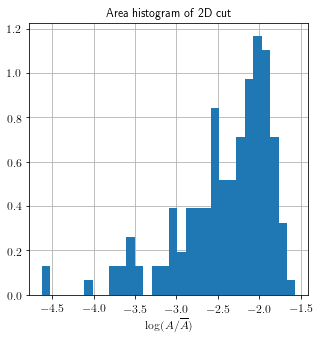

In [47]:
file = basefolder+"/Results.csv"
out_file = file.split("/")[0]
areas = load_results(file)
tot_area = np.sum(areas)
print("Total area: %f" % tot_area)
areas = areas / tot_area

plt.figure(figsize=(5,5))
plt.hist(np.log10(areas),bins=30, density=True)
plt.title("Area histogram of 2D cut")
plt.xlabel(r"$\log(A/\overline{A})$")
plt.grid()

plt.savefig(out_file+"/area_histogram.pdf")
plt.show()